# mamba
## 获取数据

In [ ]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2024, 1, 1)
# end = datetime.datetime.today()
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

In [ ]:
df.iloc[:,:-1]

In [ ]:
import numpy as np
df_da = df.iloc[:,:-2]
print(df_da.shape)
# print(df_ta.mean())
# print(df_ta.std())
# noise = np.random.normal(0, 10, df_ta.shape)

noise = np.random.normal(0, 10, df_da.shape)
noise.shape
# df_da += noise

# print((df_ta+noise).mean())
# print((df_ta+noise).std())


In [ ]:
import numpy as np

mem_his_days=5
per_days=10

# 股票数据
df['label'] = df['Close'].shift(-per_days)
# 加入噪声
df_da = df.iloc[:,:-2]
# noise = np.random.normal(0, 10, df_da.shape)
# df_da += noise

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,:-2])

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)
print(len(X_lately))

## 制作数据集

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(X_lately))

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 训练数据
batch, length, dim = 64, 5, 4
# noise = np.random.normal(sca_X.mean(), 0.05*sca_X.std(), X_train.shape)
# X_train += noise
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# # 虚拟数据
X_train_tensor = torch.randn(1351,5,4)
y_train_tensor = torch.randn(1351,1)
X_test_tensor = torch.randn(150,5,4)
y_test_tensor = torch.randn(150,1)

# 定义训练集数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True,drop_last=False)

# 定义测试集数据加载器
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

## 原始模型

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from modules.model_mamba import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size,conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x):
        x = self.fc1(x)
        x = self.mamba(x)
        x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(x)
        return x

# 初始化模型
model_mam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                          conv_width=4, expand_factor=2, output_dim=1)
print(model_mam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_mam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 训练模型
losses_mam = []
mse_test_mam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_mam.train()
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape,y_batch.shape)
        y_pred = model_mam(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_mam.append(loss.item())
    # # 评价
    # model_mam.eval()
    # y_pred_batch = y_test_tensor
    # with torch.no_grad():
    #     for inputs, labels in test_loader:
    #         outputs = model_mam(inputs)
    #         y_pred_batch = torch.cat((y_pred_batch,outputs),dim=0)
    # mse = mean_squared_error(y_pred_batch[:y_test_tensor.shape[0]] , y_pred_batch[y_test_tensor.shape[0]:])
    # 评价
    model_mam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_mam(x_test_batch)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    # 打印
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')


In [ ]:
model_mam.mamba.deltaB_u.shape
# model_mam.mamba.Luen_grad.shape
model_mam.mamba.L.shape

In [ ]:
# 绘制 loss 曲线
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y = np.array(losses_mam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 150)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")
plt.show()

# 测试数据
# x = np.linspace(1,num_epochs)
y = np.array(mse_test_mam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 100)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")

plt.show()

### 预测

In [ ]:
# 预测误差
from sklearn.metrics import mean_squared_error

model_mam.eval()
with torch.no_grad():
    y_pred = model_mam(X_test_tensor)
# print(f"Predicted shape: {y_pred.shape}")
mse = mean_squared_error(y_pred , y_test)
print(mse)



In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

### 结果评价

In [ ]:
# 计算残差
y_e = y_pred[:,0]-y_test
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_e,color='gray',label='price')
plt.show()

In [ ]:
# 对残差纯随机性检验
import numpy as np
import statsmodels.api as sm

data = y_e
# 进行 LBQ 检验，设置 lags 参数为需要检验的自相关阶数
lags = 30  # 选择检验的最大自相关阶数
lbq_test = sm.stats.acorr_ljungbox(data, lags=lags)
print(lbq_test)

# lb_stat 越小，残差自相关性越弱
# p 大于 0.05 才支持 纯随机 假设

## karma
### L size(1xn) in scan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from modules.model_Lsize_1xn_in_xProj import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        grad_mem = latest_gradient[:,2]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

In [ ]:
# 绘制 loss 曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y = np.array(losses_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 150)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")
plt.show()

# 测试数据
# x = np.linspace(1,num_epochs)
y = np.array(mse_test_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 100)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")


plt.show()

In [ ]:
x.shape,y.shape

In [ ]:
model.mamba.L

### L size(bxn) in scan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # # 评价
    # model_kam.eval()
    # y_pred_batch = y_test_tensor
    # with torch.no_grad():
    #     for inputs, labels in test_loader:
    #         outputs = model_kam(inputs,latest_gradient)
    #         y_pred_batch = torch.cat((y_pred_batch,outputs),dim=0)
    # mse = mean_squared_error(y_pred_batch[:y_test_tensor.shape[0]] , y_pred_batch[y_test_tensor.shape[0]:])

    # 评价
    model_kam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)


    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

In [ ]:
# print(x_batch.shape,latest_gradient.shape)
# print(X_test_tensor[:64].shape,latest_gradient.shape)
model_kam.mamba.delta.shape
latest_gradient.shape
# model_kam.mamba.As
# model_kam.mamba.L.shape
# x_batch.shape
# X_test_tensor[i*batch:(i+1)*batch].shape
# model_kam.mamba.L.shape
# outputs.shape

In [ ]:
# 绘制 loss 曲线
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 训练数据
x = np.linspace(1,num_epochs,num_epochs)
y = np.array(losses_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 150)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")
plt.show()

# 测试数据
# x = np.linspace(1,num_epochs)
y = np.array(mse_test_kam)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Testing loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(40, 80)  # 设置X轴范围
inset_ax.set_ylim(0, 100)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")


plt.show()

### deltaL size(bxn) in scan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_Lsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

In [ ]:
model_kam.mamba.delta.shape
latest_gradient.shape
# model_kam.mamba.As
# model_kam.mamba.L.shape
# x_batch.shape
# X_test_tensor[i*batch:(i+1)*batch].shape
# model_kam.mamba.L.shape
# outputs.shape

In [ ]:
import einops
print(model_kam.mamba.deltaA.shape)
print(x_batch.shape[0],', 64, 16')
print(model_kam.mamba.deltaB_u.shape)
# print(latest_gradient.shape)
# print(model_kam.mamba.L.shape)
# X_test_tensor[i*batch:(i+1)*batch].shape

b,l,n=model_kam.mamba.deltaB_u.shape[0],5,16
grad = latest_gradient[:b]
delta = model_kam.mamba.delta
L = einops.repeat(model_kam.mamba.L,'b n -> b l n',l=l)[:b] # 也可直接设置L(b l n)
deltaL_grad = einops.einsum(delta, L, grad, 'b l d_in, b l n, b l d_in -> b l d_in n')
print(deltaL_grad.shape)

### 加入当前步grad

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_deltaLsize_bxn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch)
        loss = criterion(y_pred, y_batch)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        x_test_batch.requires_grad = True
        y_pred_batch = model_kam(x_test_batch)
        loss = criterion(y_pred_batch, y_test_batch)
        # hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        optimizer.zero_grad()
        loss.backward()
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    # # 评价
    # model_kam.eval()
    # y_pred = []
    # for x_test_batch,y_test_batch in test_loader:
    #     with torch.no_grad():
    #         y_pred_batch = model_kam(x_test_batch,latest_gradient)
    #         y_pred.append(y_pred_batch)
    # y_pred = torch.cat(tuple(y_pred),dim=0)
    # mse = mean_squared_error(y_pred , y_test_tensor)

    hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

In [ ]:
print(model_kam.mamba.L.shape)
print(latest_gradient.shape)

model_kam.mamba.deltaB_u.shape

In [ ]:
import einops
# print(model_kam.mamba.deltaA.shape)
# print(x_batch.shape[0],', 64, 16')
# print(model_kam.mamba.deltaB_u.shape)
# print(latest_gradient.shape)
# print(model_kam.mamba.L.shape)
# X_test_tensor[i*batch:(i+1)*batch].shape

b,l,n=model_kam.mamba.deltaB_u.shape[0],5,16
grad = latest_gradient[:b]
delta = model_kam.mamba.delta
L = einops.repeat(model_kam.mamba.L,'b n -> b l n',l=l)[:b] # 也可直接设置L(b l n)
deltaL_grad = einops.einsum(L, grad, 'b l n, b l d_in -> b l d_in n')
print(L.shape)
print(grad.shape)
print(deltaL_grad.shape)

### deltaL size(1xn) in scan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from model_deltaLsize_1xn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# np.random.seed(6)
torch.manual_seed(3)
# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient

# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape,end='')
        # print(latest_gradient.shape)
        # print(latest_gradient.grad)
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)
        
        # print(latest_gradient)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        # print(model_kam.mamba.out_proj.weight)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # latest_gradient = model_kam.mamba.intermediate_output
        # print(model_kam.mamba.out_proj.weight)

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred_list = []
    y_test_list = []
    for x_test_batch,y_test_batch in test_loader:
        y_test_list.append(y_test_batch)
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch,latest_gradient)
            y_pred_list.append(y_pred_batch)
    y_pred_lists = torch.cat(tuple(y_pred_list),dim=0)
    y_test_lists = torch.cat(tuple(y_test_list),dim=0)
    mse = mean_squared_error(y_pred_lists , y_test_lists)
    mse_test_kam.append(mse)

    # hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
# hook_handle.remove()

In [ ]:
import einops
print(model_kam.mamba.deltaA.shape)
print(x_batch.shape[0],', 64, 16')
print(model_kam.mamba.deltaB_u.shape)
# print(latest_gradient.shape)
print(model_kam.mamba.L.shape)
# X_test_tensor[i*batch:(i+1)*batch].shape

l,n=5,16
b = min(x_batch.shape[0],latest_gradient.shape[0])
grad = latest_gradient[:b]
delta = model_kam.mamba.delta[:b]
Li = model_kam.mamba.L
L = einops.repeat(Li,'n -> b l n',l=l,b=b) # 也可直接设置L(b l n)
deltaL_grad = einops.einsum(delta, L, grad, 'b l d_in, b l n, b l d_in -> b l d_in n')
print(deltaL_grad.shape)

In [ ]:
latest_gradient.shape

In [ ]:
150%64

### deltaL size(bln) in scan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from modules.model_Lsize_1xn_in_xProj import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient
# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 500
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    # print(latest_gradient)
    for x_batch, y_batch in train_loader:
        y_pred = model_kam(x_batch,latest_gradient)
        loss = criterion(y_pred, y_batch)
        # print(latest_gradient)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(latest_gradient)

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred_list = []
    y_test_list = []
    for x_test_batch,y_test_batch in test_loader:
        y_test_list.append(y_test_batch)
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch)
            y_pred_list.append(y_pred_batch)
    y_pred_lists = torch.cat(tuple(y_pred_list),dim=0)
    y_test_lists = torch.cat(tuple(y_test_list),dim=0)
    mse = mean_squared_error(y_pred_lists , y_test_lists)
    mse_test_kam.append(mse)

    # hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
hook_handle.remove()

In [ ]:
# print(y_pred_lists.T)
# print(mse_test_kam)
print(model_kam.mamba.L)

### save all grad

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from modules.model_Lsize_1xn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, batch_size=batch,
                      conv_width=4, expand_factor=2, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
gradient_list = [None]*50
def hook_fn(grad):
    global latest_gradient
    # latest_gradient = grad if grad.shape[0]==batch else latest_gradient
    latest_gradient = grad
    
    # gradient_list.append(grad)
    
# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for batch_index,(x_batch, y_batch) in enumerate(train_loader):
        y_pred = model_kam(x_batch,gradient_list[batch_index])
        loss = criterion(y_pred, y_batch)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(batch_index,latest_gradient.shape)
        gradient_list[batch_index] = latest_gradient

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred_list = []
    y_test_list = []
    for x_test_batch,y_test_batch in test_loader:
        y_test_list.append(y_test_batch)
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch)
            y_pred_list.append(y_pred_batch)
    y_pred_lists = torch.cat(tuple(y_pred_list),dim=0)
    y_test_lists = torch.cat(tuple(y_test_list),dim=0)
    mse = mean_squared_error(y_pred_lists , y_test_lists)
    mse_test_kam.append(mse)

    # hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
hook_handle.remove()

In [ ]:
gradient_list[0].shape

In [ ]:
import numpy as np
def make_hippo(N):
    P = np.sqrt(1 + 2 * np.arange(N))
    A = P[:, np.newaxis] * P[np.newaxis, :]
    A = np.tril(A) - np.diag(np.arange(N))
    return -A
A = make_hippo(5)
print(A)
eigenvalues, eigenvectors = np.linalg.eig(A)
print("特征值:", eigenvalues)

In [ ]:
import numpy as np
A = model_kam.mamba.deltaA.detach().numpy()[0,0]

# A = einops.repeat(torch.arange(1, 64 + 1), 'n -> d n', d=64)
# A_log = torch.log(A)
# A = -torch.exp(A_log.float()).detach().numpy()

C = model_kam.mamba.C.detach().numpy()[0,0]
L = model_kam.mamba.L.detach().numpy()

L = find_L(A,C)


M = A-einops.einsum(L,C, 'd_in, n -> d_in n')
# M = A-np.eye(64)
eigenvalues, eigenvectors = np.linalg.eig(M)

print("特征值:", eigenvalues)
# print("特征向量:", eigenvectors)

# U, s, VT = np.linalg.svd(A, full_matrices=False)

# 奇异值 s 是按降序排列的
# print("奇异值:", s[0,0])

In [ ]:
import numpy as np
from scipy.linalg import solve_discrete_are

A = make_hippo(64)  # 示例矩阵，需要替换为实际的A矩阵
C = np.random.rand(1, 64)   # 示例矩阵，需要替换为实际的C矩阵

# A = model_kam.mamba.deltaA.detach().numpy()[0,0]
# C = model_kam.mamba.C.detach().numpy()[0,0]

def find_L(A,C):
    Q = np.eye(64)*10  # 示例协方差矩阵，需要根据实际情况替换
    R = np.eye(1)*0.1   # 示例协方差矩阵，需要根据实际情况替换
    # 求解Riccati方程
    P = solve_discrete_are(A.T, C.T, Q, R)
    # 计算观测器增益L
    L = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)
    return L
L = find_L(A,C)

M = A-L*C

print("观测器增益L：")
print(L)


In [ ]:
M = A-L*C
eigenvalues, eigenvectors = np.linalg.eig(M)
print("特征值:", eigenvalues)

In [ ]:
(L*C).shape

In [ ]:
!pip install cvxpy


In [ ]:
import numpy as np
import cvxpy as cp

# 定义系统矩阵 A 和 C
A = np.array([[1.0, 2.0], 
              [3.0, 4.0]])
C = np.array([[1.0, 0.0]])

# 定义 L 的形状
n, m = A.shape[0], C.shape[0]
L = cp.Variable((n, m))

# 定义 Lyapunov 矩阵 P（对称正定）
P = cp.Variable((n, n), symmetric=True)

# 定义 LMI 约束
Q = np.eye(n)  # 可以选择任意对称正定矩阵
constraints = [
    P >> 0,  # P 必须是正定的
    (A - L @ C).T @ P + P @ (A - L @ C) << -Q  # LMI 约束
]

# 定义优化问题
objective = cp.Minimize(cp.trace(P))  # 可以使用任何凸目标函数，这里是最小化 P 的迹

# 求解优化问题
prob = cp.Problem(objective, constraints)
prob.solve()

# 输出结果
L_opt = L.value
P_opt = P.value

print("Optimal L:", L_opt)
print("Optimal P:", P_opt)


In [ ]:
print(model_kam.mamba.deltaA.shape)
print(model_kam.mamba.L.shape)
print(model_kam.mamba.C.shape)


In [ ]:
import einops
A = einops.repeat(torch.arange(1, 64 + 1), 'n -> d n', d=64)
A_log = torch.log(A)
A = -torch.exp(A_log.float())

M = A-np.eye(64)
eigenvalues, eigenvectors = np.linalg.eig(M)

print("特征值:", eigenvalues)
print(A.shape)
print(A)

# relu

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 定义Haar小波函数
def haar_wavelet(x):
    # Haar小波函数的定义
    condition = (x >= 0) & (x < 1)
    return torch.where(condition, 1.0, -1.0)

# 定义高斯径向基函数
def Daubechies(x):
    y = np.cos(1.75 * x) * np.exp(-x**2 / 2.0)
    return y

# 定义一个简单的神经网络模型
class WaveletNet(torch.nn.Module):
    def __init__(self):
        super(WaveletNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)  # 输入特征为1，输出特征为10
        self.fc2 = torch.nn.Linear(10, 1)  # 输入特征为10，输出特征为1

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)  # 这里使用ReLU作为隐层激活函数，也可以替换为小波基函数
        # x = haar_wavelet(x)
        x = self.fc2(x)
        return x

# 生成一些示例数据
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(3) + 0.1 * torch.randn(x.size())

# 实例化模型和优化器
model = WaveletNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# 训练模型
losses = []
num_epochs = 100
for epoch in range(num_epochs):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 绘制损失曲线
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 绘制拟合曲线
model.eval()
with torch.no_grad():
    y_pred = model(x)
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Original data')
plt.plot(x.numpy(), y_pred.numpy(), color='red', linewidth=2, label='Fitted line')
plt.legend()
plt.title('Wavelet Activation Function Fit')
plt.show()


In [ ]:
x = np.linspace(-1,1,40)
y = x
plt.plot(x,F.relu(x))
plt.grid(True, linestyle='--')
plt.show()


# AKF

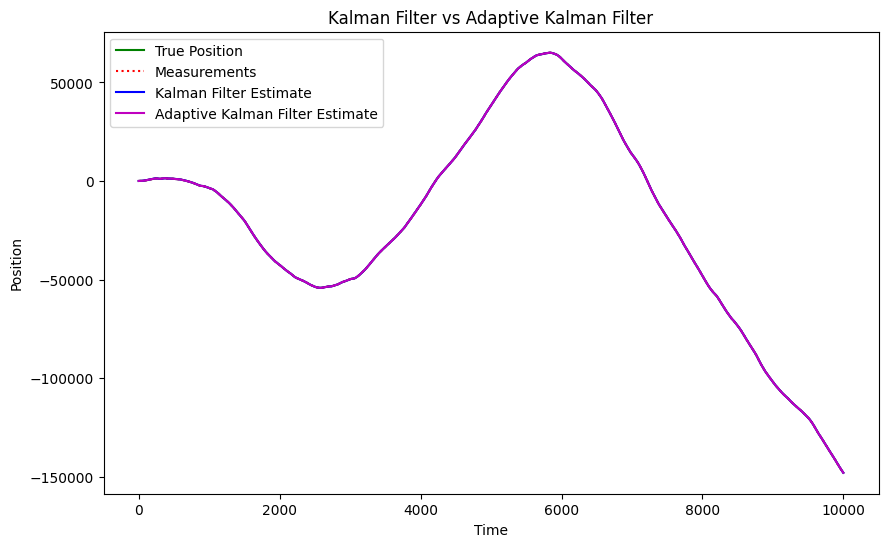

In [270]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(20)
# 生成模拟数据，使用协方差生成实际噪声
def generate_data(T, process_noise_var, observation_noise_var):
    x = np.zeros((T, 2))  # [position, velocity]
    z = np.zeros(T)       # observations (only position is observed)
    
    x[0] = [0, 1]  # Initial position 0, velocity 1
    z[0] = x[0, 0] + np.random.normal(0, np.sqrt(observation_noise_var[0]))
    
    for t in range(1, T):
        # 实际生成过程噪声和观测噪声
        process_noise = np.random.normal(0, np.sqrt(process_noise_var[t]), 2)
        observation_noise = np.random.normal(0, np.sqrt(observation_noise_var[t]))
        
        x[t] = np.dot(A, x[t-1]) + process_noise  # 更新状态（带有过程噪声）
        z[t] = x[t, 0] + observation_noise        # 生成观测值（带有观测噪声）
    
    return x, z

# 标准卡尔曼滤波器
def kalman_filter(T, z, Q, R):
    x_hat = np.zeros((T, 2))
    P = np.eye(2) * 1000  # 初始的不确定性
    for t in range(1, T):
        # 预测步骤
        x_hat[t] = np.dot(A, x_hat[t-1])
        P = np.dot(A, np.dot(P, A.T)) + Q

        # 更新步骤
        K = np.dot(P, H.T) / (np.dot(H, np.dot(P, H.T)) + R[t])  # 卡尔曼增益
        x_hat[t] = x_hat[t] + K * (z[t] - np.dot(H, x_hat[t]))    # 更新状态估计
        P = (np.eye(2) - np.dot(K, H)) * P  # 更新误差协方差
    
    return x_hat

# 自适应卡尔曼滤波器
def adaptive_kalman_filter(T, z, Q_initial, R_initial):
    x_hat = np.zeros((T, 2))
    P = np.eye(2) * 100  # 初始的不确定性
    Q = Q_initial.copy()
    R = R_initial.copy()
    
    for t in range(1, T):
        # 预测步骤
        x_hat[t] = np.dot(A, x_hat[t-1])
        P = np.dot(A, np.dot(P, A.T)) + Q

        # 更新步骤
        K = np.dot(P, H.T) / (np.dot(H, np.dot(P, H.T)) + R[t])
        x_hat[t] = x_hat[t] + K * (z[t] - np.dot(H, x_hat[t]))
        P = (np.eye(2) - np.dot(K, H)) * P

        # 自适应调整噪声
        innovation = z[t] - np.dot(H, x_hat[t])
        Q = np.eye(2) * max(np.var(innovation), 1e-4)  # 自适应更新Q
        R[t] = max(np.var(innovation), 1e-4)           # 自适应更新R
        # print(innovation,Q,R)
    
    return x_hat

# 参数设置
T = 10000  # 时间步数
dt = 1.0  # 时间间隔

A = np.array([[1, dt], [0, 1]])  # 状态转移矩阵
H = np.array([1, 0])             # 观测矩阵

# 过程噪声和观测噪声的时变协方差
# process_noise_var = np.linspace(1, 2.0, T)  # 时变过程噪声协方差
# observation_noise_var = np.linspace(1, 2.0, T)  # 时变观测噪声协方差
process_noise_var = np.ones(T)*1  # 时变过程噪声协方差
observation_noise_var = np.ones(T)*1  # 时变观测噪声协方差

# 生成带有实际噪声的数据
x, z = generate_data(T, process_noise_var, observation_noise_var)

# 初始噪声协方差矩阵
Q_initial = np.eye(2) * 1.0
R_initial = np.ones(T) * 1.0

# 应用卡尔曼滤波
x_hat_kf = kalman_filter(T, z, Q_initial, R_initial)

# 应用自适应卡尔曼滤波
x_hat_akf = adaptive_kalman_filter(T, z, Q_initial, R_initial)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x[:, 0], label="True Position", color='g')
plt.plot(z, label="Measurements", color='r', linestyle='dotted')
plt.plot(x_hat_kf[:, 0], label="Kalman Filter Estimate", color='b')
plt.plot(x_hat_akf[:, 0], label="Adaptive Kalman Filter Estimate", color='m')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Kalman Filter vs Adaptive Kalman Filter')
plt.show()


In [227]:
x[:, 0][1:5]

array([ 2.95865022, -3.31431049, -2.92679286, 15.51111369])

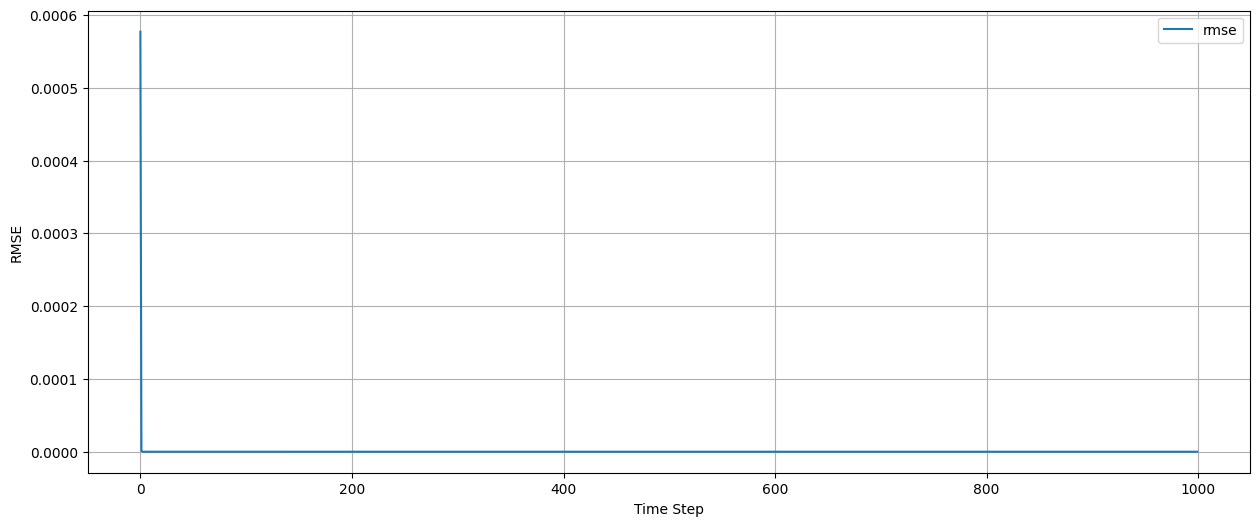

In [268]:
from sklearn.metrics import mean_squared_error
rmse_list = []
true_values = x[:, 0]
predicted_values = x_hat_akf[:, 0]
for i in range(len(true_values)):
    if i%10==0:
        rmse = mean_squared_error(true_values[i:i+100],predicted_values[i:i+100])**0.5
        rmse_list.append(rmse)
# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(rmse_list, label='rmse')
plt.xlabel('Time Step')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [234]:
rmse_list

[14.480974502885566,
 13.806038089714516,
 10.55979586725105,
 11.642116873162557,
 10.184264995372509,
 9.727775076554547,
 9.420028041682071,
 11.616100897710288,
 10.960426336505147,
 6.08889014884405,
 7.90018445005514,
 10.020987616919756,
 10.936071356102591,
 8.796836827996906,
 5.651005087176271,
 8.551613526676112,
 10.894696587820476,
 6.459162906858043,
 14.353201743371441,
 7.023557190594266,
 11.99878823767124,
 11.35591526018909,
 6.25796890616128,
 8.746403906383835,
 8.59194919438742,
 12.824763449021129,
 10.34671696715726,
 6.74663445224748,
 12.68207771928114,
 9.713905853836206,
 9.72679859433446,
 9.099074271184012,
 11.093200312419789,
 7.016669247840904,
 10.122867459611738,
 12.928088083934666,
 9.146320089253264,
 10.73784001065862,
 12.153184474128201,
 11.639243454586586,
 5.564603639923191,
 9.59781403318681,
 11.635402378621885,
 8.82585149184162,
 8.670094248568846,
 10.875653061079117,
 9.374861151674295,
 8.364253730426295,
 5.780088807927241,
 10.803756

In [264]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
class AdaptiveKalmanFilter:
    def __init__(self, A, B, H, Q_init, R_init, P_init, x_init):
        self.A = A  # 状态转移矩阵
        self.B = B  # 控制输入矩阵
        self.H = H  # 观测矩阵
        self.Q = Q_init  # 初始化过程噪声协方差矩阵
        self.R = R_init  # 初始化观测噪声协方差矩阵
        self.P = P_init  # 状态协方差矩阵
        self.x = x_init  # 初始状态
        a = 0.01
        self.alpha = a # 更新率
        self.beta = a

    def predict(self, u):
        self.x = self.A @ self.x + self.B @ u
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, z):
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        y = z - self.H @ self.x
        self.x = self.x + K @ y
        self.P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        # self.adapt_Q_R(y)

    def adapt_Q_R(self, y):
        residual = y.T @ y
        self.Q = (1 - self.alpha) * residual * np.eye(self.A.shape[0]) + self.alpha * self.Q
        self.R = (1 - self.beta) * residual * np.eye(self.H.shape[0]) + self.beta * self.R

    def get_state(self):
        return self.x

# 系统模型定义
dt = 1.0
A = np.array([[1, dt], [0, 1]])
B = np.array([[0], [0]])
H = np.array([[1, 0]])

# 初始估计和协方差矩阵
Q_init = np.eye(2)
R_init = np.eye(1)
P_init = np.eye(2)
x_init = np.array([[0], [1]])

# 创建自适应卡尔曼滤波器实例
akf = AdaptiveKalmanFilter(A, B, H, Q_init, R_init, P_init, x_init)

# 存储数据
true_values = []
observed_values = []
predicted_values = []

# 模拟若干步的预测和更新
for k in range(50000):
    u = np.array([[0]])
    true_value = 0  # 真实值，加入一些变化
    z = np.array([[true_value + np.random.normal(0, 10)]])  # 观测值

    akf.predict(u)
    predicted_values.append(akf.get_state()[0, 0])
    akf.update(z)

    true_values.append(true_value)
    observed_values.append(z[0, 0])

In [244]:
print(akf.Q,akf.R)

[[1. 0.]
 [0. 1.]] [[1.]]


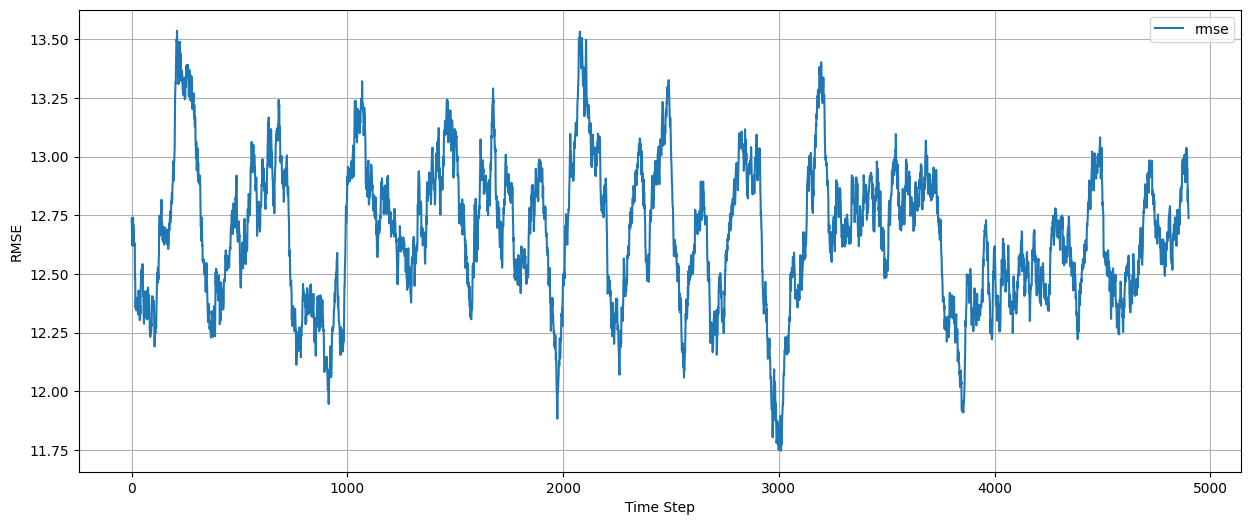

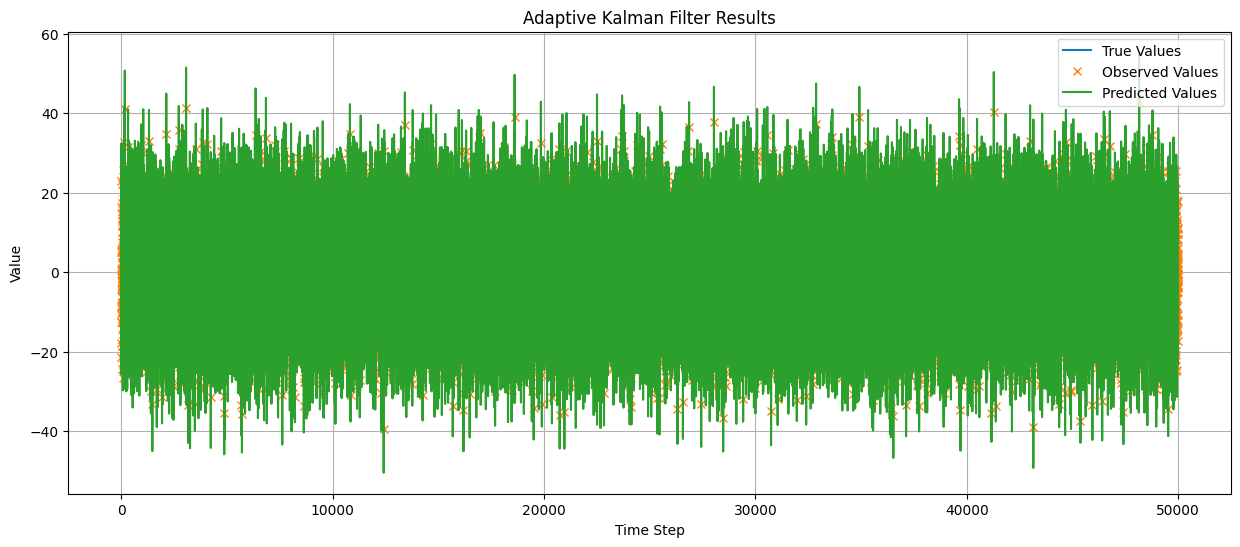

In [265]:
from sklearn.metrics import mean_squared_error
rmse_list = []
for i in range(len(true_values)):
    if i%10==0:
        rmse = mean_squared_error(true_values[i:i+1000],predicted_values[i:i+1000])**0.5
        rmse_list.append(rmse)
# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(rmse_list[:-100], label='rmse')
plt.xlabel('Time Step')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(true_values, label='True Values')
plt.plot(observed_values, label='Observed Values', marker='x', linestyle='None')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Adaptive Kalman Filter Results')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()